## Fresh Peaches Sales Forecast

In [18]:
import pandas as pd

# Load your cleaned_data.csv
df = pd.read_csv("cleaned_data.csv")

# Parse types
df['order_day']   = pd.to_datetime(df['order_day'], errors='coerce')
df['total_sales'] = pd.to_numeric(df['total_sales'], errors='coerce').fillna(0)

# 1) Create a proper daily date column
df['date'] = df['order_day'].dt.normalize()   # midnight of each day

# 2) Aggregate to one row per day
daily = (
    df.groupby('date', as_index=False)['total_sales']
      .sum()
      .rename(columns={'total_sales': 'sales'})
      .sort_values('date')
      .reset_index(drop=True)
)

# 3) Ensure continuous daily index (fill missing days with 0)
full_range = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')
daily = (
    daily.set_index('date')
         .reindex(full_range)
         .fillna(0.0)
         .rename_axis('date')
         .reset_index()
)

#### Linear Regression for Daily Sales Forecast

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

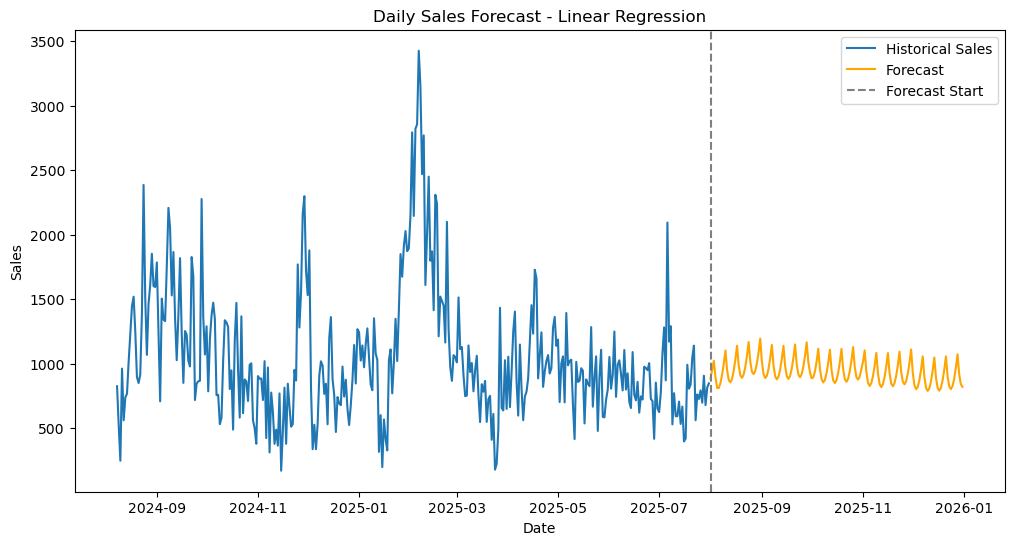

In [23]:
# ----- 1. Feature Engineering -----
df = daily.copy()

# Calendar features
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['dayofyear'] = df['date'].dt.dayofyear

# Lag features (yesterday, last week)
df['lag_1'] = df['sales'].shift(1)
df['lag_7'] = df['sales'].shift(7)

# Drop NA from early rows due to lags
df = df.dropna().reset_index(drop=True)

FEATURES = ['dayofweek', 'month', 'dayofyear', 'lag_1', 'lag_7']
TARGET = 'sales'

# ----- 2. Train-Test Split -----
train_df = df[df['date'] < '2025-08-01']   # train until July 31, 2025
forecast_start = pd.Timestamp('2025-08-01')
forecast_end = pd.Timestamp('2025-12-31')

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

# ----- 3. Train Linear Regression Model -----
lr = LinearRegression()
lr.fit(X_train, y_train)

# ----- 4. Recursive Forecast -----
history = df.copy()
preds = []

current_date = forecast_start
while current_date <= forecast_end:
    temp = pd.DataFrame({'date': [current_date]})
    temp['dayofweek'] = temp['date'].dt.dayofweek
    temp['month'] = temp['date'].dt.month
    temp['dayofyear'] = temp['date'].dt.dayofyear
    
    # Get lag values from history
    lag_1_val = history.loc[history['date'] == current_date - pd.Timedelta(days=1), 'sales'].values
    lag_7_val = history.loc[history['date'] == current_date - pd.Timedelta(days=7), 'sales'].values
    
    # Fallback to mean if lag not available
    temp['lag_1'] = lag_1_val[0] if len(lag_1_val) else history['sales'].mean()
    temp['lag_7'] = lag_7_val[0] if len(lag_7_val) else history['sales'].mean()
    
    # Predict
    yhat = lr.predict(temp[FEATURES])[0]
    preds.append({'date': current_date, 'forecast': yhat})
    
    # Add prediction to history for next day's lag calculation
    history = pd.concat([history, pd.DataFrame({'date': [current_date], 'sales': [yhat]})], ignore_index=True)
    
    current_date += pd.Timedelta(days=1)

forecast_df = pd.DataFrame(preds)

# ----- 5. Plot -----
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['sales'], label='Historical Sales')
plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecast', color='orange')
plt.axvline(forecast_start, linestyle='--', color='gray', label='Forecast Start')
plt.title('Daily Sales Forecast - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Save forecast
forecast_df.to_csv("linear_regression_forecast.csv", index=False)

In [35]:
from sklearn.metrics import r2_score

# Validation split: last 30 days before Aug 2025
val_cut = pd.Timestamp('2025-07-01')
fit_df = df[df['date'] < val_cut]
val_df = df[(df['date'] >= val_cut) & (df['date'] < forecast_start)]

# Train
lr.fit(fit_df[FEATURES], fit_df[TARGET])

# Predict on validation
y_pred_val = lr.predict(val_df[FEATURES])

# R² score
r2 = r2_score(val_df[TARGET], y_pred_val)
print("Validation R²:", r2)

Validation R²: 0.14565037826661642


#### Logistical Regression Model for Daily Sales Forecast

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

Validation — acc=0.844  prec=0.455  rec=0.833  F1=0.588  (thr=0.31)


/var/folders/q7/zjfk4hdx0ss5gnlksy_ljmqr0000gn/T/ipykernel_57041/4056928247.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(pipe.predict_proba(row[FEATURES])[:,1])
/var/folders/q7/zjfk4hdx0ss5gnlksy_ljmqr0000gn/T/ipykernel_57041/4056928247.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(pipe.predict_proba(row[FEATURES])[:,1])
/var/folders/q7/zjfk4hdx0ss5gnlksy_ljmqr0000gn/T/ipykernel_57041/4056928247.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. 

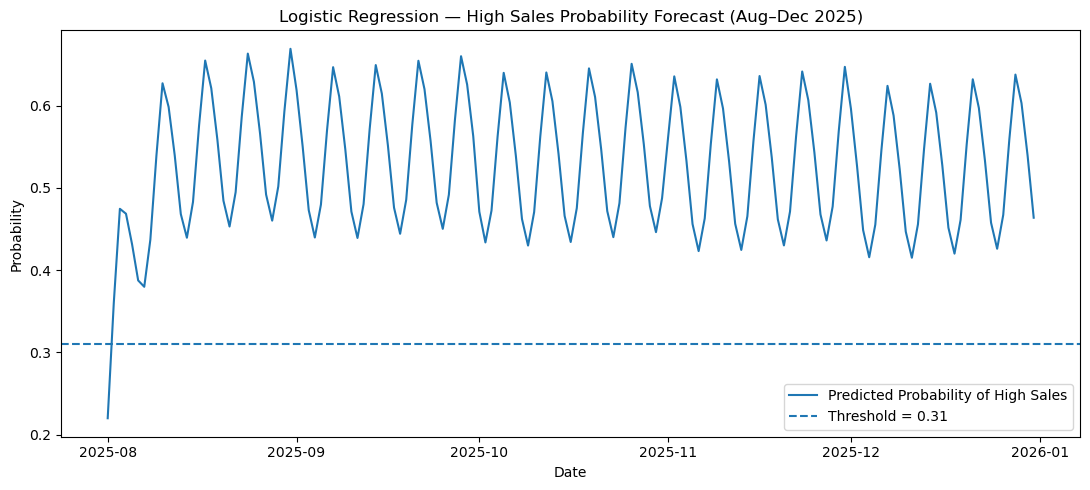

Saved: logistic_high_sales_forecast_balanced_2025.csv


In [38]:
# ---------------------------
# 1) FEATURES + TARGET
# ---------------------------
df = daily.copy().sort_values("date").reset_index(drop=True)

# Lags & rollings
df["lag_1"]  = df["sales"].shift(1)
df["lag_7"]  = df["sales"].shift(7)
df["rmean_7"]  = df["sales"].shift(1).rolling(7).mean()
df["rmean_14"] = df["sales"].shift(1).rolling(14).mean()

# Calendar features
df["dow"]   = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["doy"]   = df["date"].dt.dayofyear

# (optional) cyclical encodings
df["sin_dow"] = np.sin(2*np.pi*df["dow"]/7.0)
df["cos_dow"] = np.cos(2*np.pi*df["dow"]/7.0)

# Binary target: "high sales" = above 65th percentile (helps balance classes)
hi_thresh = df["sales"].quantile(0.65)
df["high_sales"] = (df["sales"] > hi_thresh).astype(int)

# Drop rows with NA features from lags/rollings
df = df.dropna().reset_index(drop=True)

FEATURES = ["lag_1","lag_7","rmean_7","rmean_14",
            "dow","month","doy","sin_dow","cos_dow"]
TARGET = "high_sales"

# ---------------------------
# 2) TIME SPLIT + PIPELINE
# ---------------------------
forecast_start = pd.Timestamp("2025-08-01")
forecast_end   = pd.Timestamp("2025-12-31")

# Train on everything strictly before forecast window
train_df = df[df["date"] < forecast_start].copy()

# Keep the last ~45 days of train as a validation window to tune threshold
val_days = 45
val_cut  = train_df["date"].max() - pd.Timedelta(days=val_days)
fit_df   = train_df[train_df["date"] <= val_cut]
val_df   = train_df[train_df["date"] >  val_cut]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

pipe.fit(fit_df[FEATURES], fit_df[TARGET])

# ---------------------------
# 3) THRESHOLD TUNING (maximize F1 on validation)
# ---------------------------
val_proba = pipe.predict_proba(val_df[FEATURES])[:,1]
best_thr, best_f1 = 0.5, -1
for thr in np.linspace(0.2, 0.8, 61):
    preds = (val_proba >= thr).astype(int)
    f1    = f1_score(val_df[TARGET], preds, zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

# Quick validation report
val_preds = (val_proba >= best_thr).astype(int)
acc = accuracy_score(val_df[TARGET], val_preds)
prec, rec, f1, _ = precision_recall_fscore_support(val_df[TARGET], val_preds, average="binary", zero_division=0)
print(f"Validation — acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  F1={f1:.3f}  (thr={best_thr:.2f})")

# ---------------------------
# 4) RECURSIVE FORECAST (Aug–Dec 2025)
# ---------------------------
history = df.copy()  # has columns date, sales, engineered cols
pred_rows = []

# Levels to simulate future "sales" for lags/rollings
low_level  = df["sales"].quantile(0.40)
high_level = df["sales"].quantile(0.80)

cur = forecast_start
while cur <= forecast_end:
    # Build one-row feature frame using current date + lag values from 'history'
    # Compute lag/rolling from history's last rows
    lag_1  = history["sales"].iloc[-1]
    lag_7  = history["sales"].iloc[-7] if len(history) >= 7 else lag_1
    rmean_7  = history["sales"].iloc[-7:].mean() if len(history) >= 7 else history["sales"].mean()
    rmean_14 = history["sales"].iloc[-14:].mean() if len(history) >= 14 else rmean_7

    row = pd.DataFrame([{
        "lag_1": lag_1,
        "lag_7": lag_7,
        "rmean_7": rmean_7,
        "rmean_14": rmean_14,
        "dow":   cur.dayofweek,
        "month": cur.month,
        "doy":   cur.dayofyear,
        "sin_dow": np.sin(2*np.pi*cur.dayofweek/7.0),
        "cos_dow": np.cos(2*np.pi*cur.dayofweek/7.0),
    }])

    prob = float(pipe.predict_proba(row[FEATURES])[:,1])
    cls  = int(prob >= best_thr)

    pred_rows.append({"date": cur, "prob_high_sales": prob, "predicted_high_sales": cls})

    # Simulate a sales value to keep lags dynamic:
    # smooth blend between low & high levels using the probability
    simulated_sales = low_level*(1.0 - prob) + high_level*prob

    history = pd.concat([history, pd.DataFrame({"date":[cur], "sales":[simulated_sales]})],
                        ignore_index=True)

    cur += pd.Timedelta(days=1)

logit_forecast = pd.DataFrame(pred_rows)

# ---------------------------
# 5) PLOTS + SAVE
# ---------------------------
plt.figure(figsize=(11,5))
plt.plot(logit_forecast["date"], logit_forecast["prob_high_sales"],
         label="Predicted Probability of High Sales")
plt.axhline(best_thr, ls="--", label=f"Threshold = {best_thr:.2f}")
plt.title("Logistic Regression — High Sales Probability Forecast (Aug–Dec 2025)")
plt.xlabel("Date"); plt.ylabel("Probability"); plt.legend(); plt.tight_layout()
plt.show()

logit_forecast.to_csv("logistic_high_sales_forecast_balanced_2025.csv", index=False)
print("Saved: logistic_high_sales_forecast_balanced_2025.csv")

In [39]:
from sklearn.metrics import r2_score
import numpy as np

# 1) R² using predicted probabilities as continuous predictions
val_proba = pipe.predict_proba(val_df[FEATURES])[:, 1]
r2_probs = r2_score(val_df[TARGET], val_proba)
print(f"R² (using probabilities) = {r2_probs:.4f}")

# 2) McFadden's pseudo R²
# log-likelihood for model
eps = 1e-15  # avoid log(0)
ll_model = np.sum(val_df[TARGET]*np.log(val_proba+eps) +
                  (1 - val_df[TARGET])*np.log(1 - val_proba+eps))

# log-likelihood for null model (just predicting mean of target)
p_null = np.mean(val_df[TARGET])
ll_null = np.sum(val_df[TARGET]*np.log(p_null+eps) +
                 (1 - val_df[TARGET])*np.log(1 - p_null+eps))

pseudo_r2 = 1 - (ll_model / ll_null)
print(f"McFadden's pseudo R² = {pseudo_r2:.4f}")

R² (using probabilities) = 0.0501
McFadden's pseudo R² = 0.0404


### Prophet

11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:41 - cmdstanpy - INFO - Chain [1] done processing


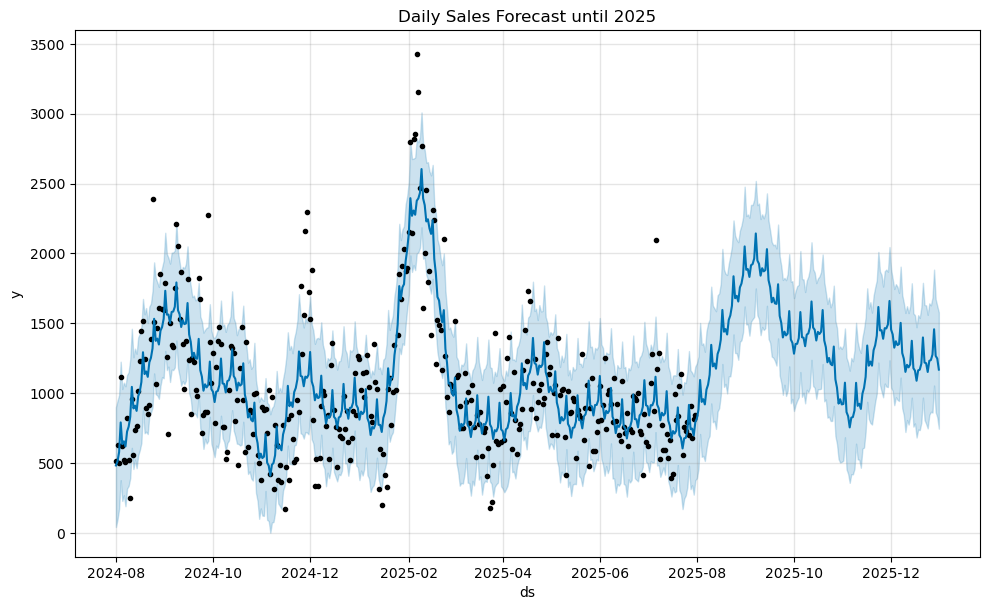

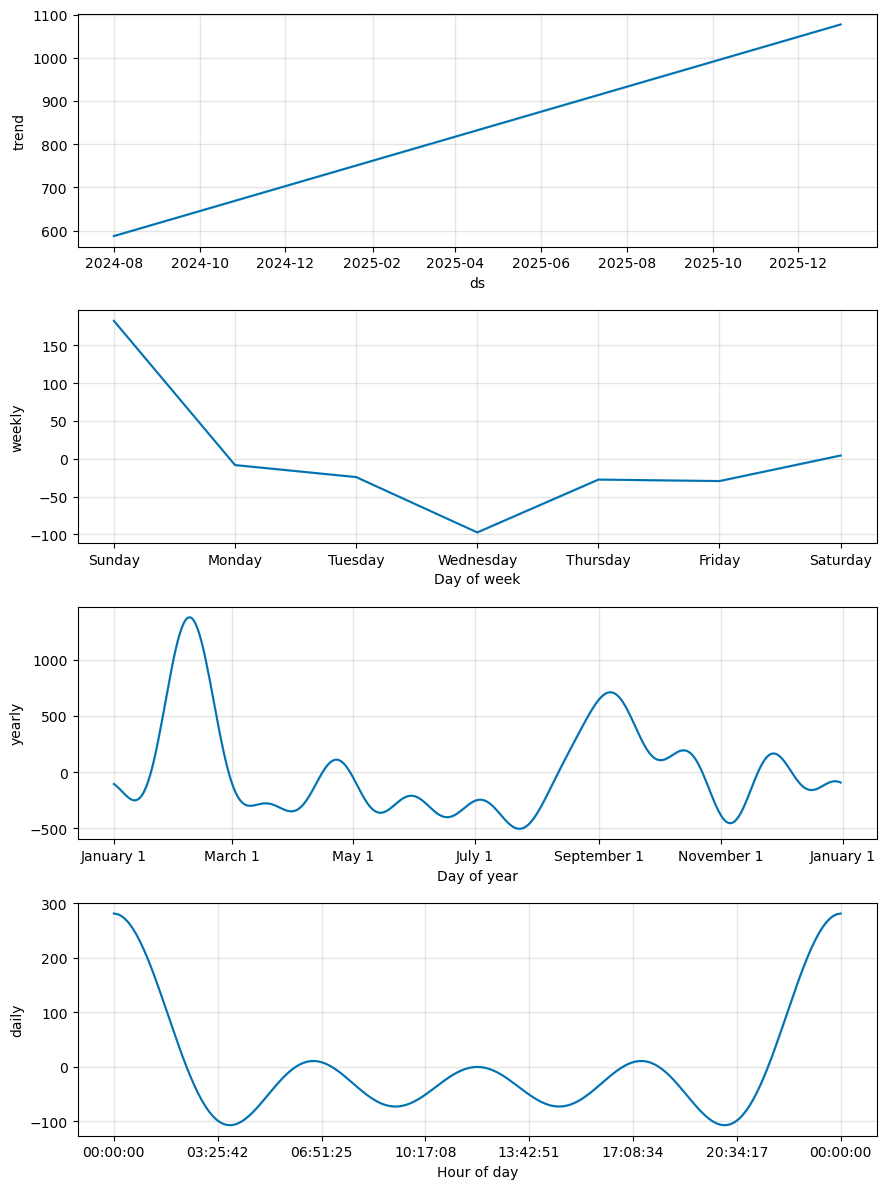

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load and prepare data
df = pd.read_csv("cleaned_data.csv")   # use the path where your CSV is saved
df['order_day'] = pd.to_datetime(df['order_day'])

# Aggregate daily sales
daily_sales = df.groupby('order_day')['total_sales'].sum().reset_index()

# Prophet requires 'ds' (date) and 'y' (value)
prophet_df = daily_sales.rename(columns={'order_day': 'ds', 'total_sales': 'y'})

# Initialize and fit the model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)

# Forecast until end of 2025
last_date = prophet_df['ds'].max()
future = model.make_future_dataframe(
    periods=(pd.to_datetime("2025-12-31") - last_date).days,
    freq="D"
)
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Daily Sales Forecast until 2025")
plt.show()

# Plot seasonality components
fig2 = model.plot_components(forecast)
plt.show()

## test accuracy

In [3]:
# Split data
train = prophet_df.iloc[:-30]   # everything except last 30 days
test = prophet_df.iloc[-30:]    # last 30 days

In [4]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(train)

# Forecast same length as test set
future = model.make_future_dataframe(periods=30, freq="D")
forecast = model.predict(future)

11:54:49 - cmdstanpy - INFO - Chain [1] start processing
11:54:49 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Only keep forecast for the test dates
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

MAE: 513.96
RMSE: 582.77


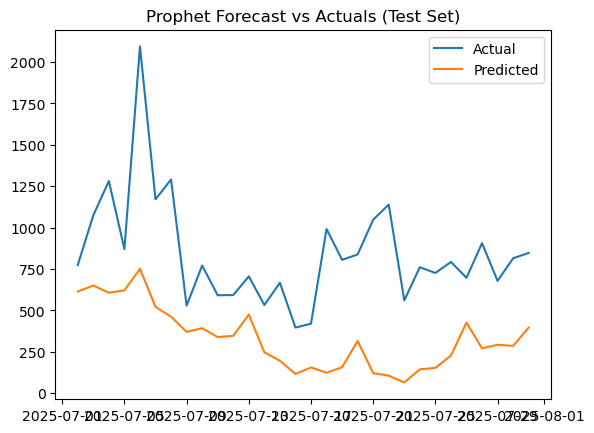

In [7]:
import matplotlib.pyplot as plt

plt.plot(test['ds'], y_true, label="Actual")
plt.plot(test['ds'], y_pred, label="Predicted")
plt.legend()
plt.title("Prophet Forecast vs Actuals (Test Set)")
plt.show()

In [8]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
print("R²:", round(r2, 3))

R²: -2.196


## SARIMA


Baseline (Naïve) on test:
  MAE: 263.51  RMSE: 383.53  R²: -0.384
[auto_arima] MAE: 406.15  RMSE: 501.57  R²: -1.368
[grid_(1, 1, 1)_(1, 1, 1, 7)] MAE: 297.11  RMSE: 407.72  R²: -0.565
[grid_(2, 1, 1)_(1, 1, 1, 7)] MAE: 313.32  RMSE: 421.72  R²: -0.674
[grid_(1, 1, 2)_(1, 1, 1, 7)] MAE: 294.92  RMSE: 405.33  R²: -0.546
[grid_(3, 0, 0)_(2, 0, 0, 7)] MAE: 406.15  RMSE: 501.57  R²: -1.368
[grid_(0, 1, 1)_(0, 1, 1, 7)] MAE: 308.58  RMSE: 417.65  R²: -0.642
[grid_(2, 0, 2)_(1, 1, 0, 7)] MAE: 287.11  RMSE: 383.61  R²: -0.385

Best by MAE: {'name': 'grid_(2, 0, 2)_(1, 1, 0, 7)', 'order': (2, 0, 2), 'so': (1, 1, 0, 7), 'MAE': 287.11208002121896, 'RMSE': 383.6056916669623, 'R2': -0.3849827120773228}


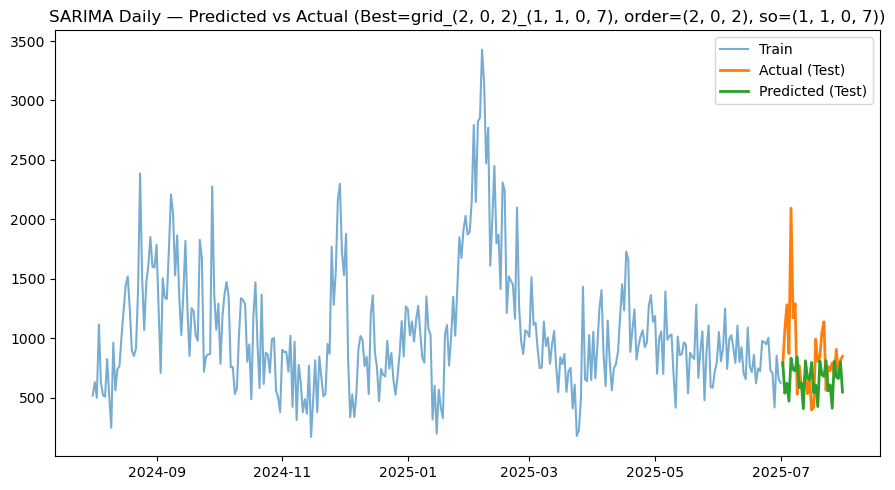

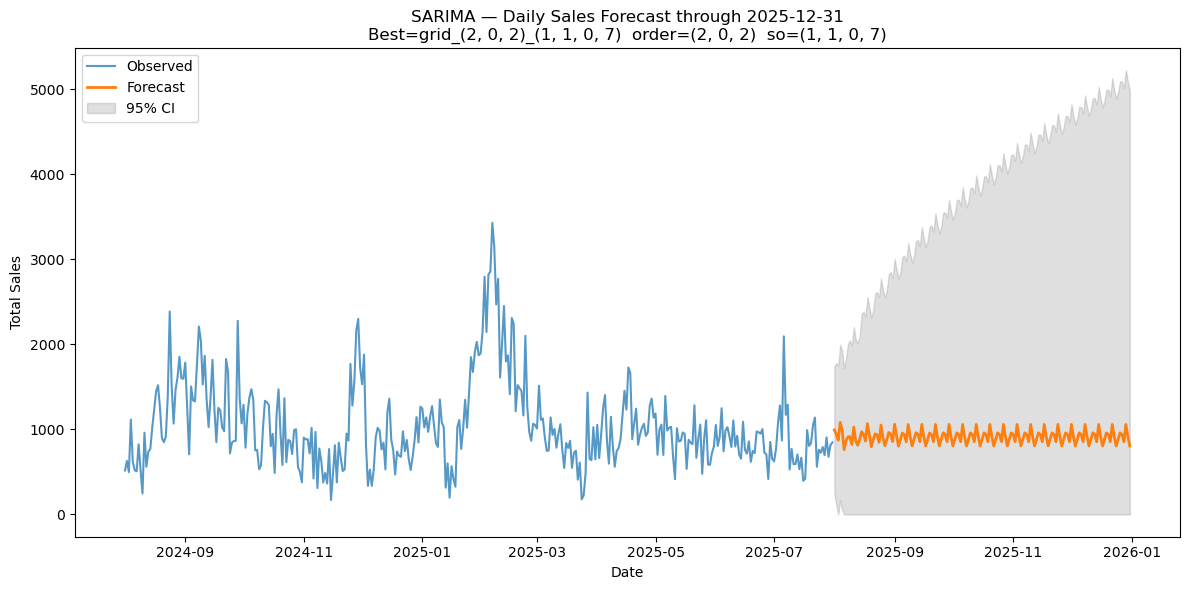

Residual mean: 8.45   Std: 380.69


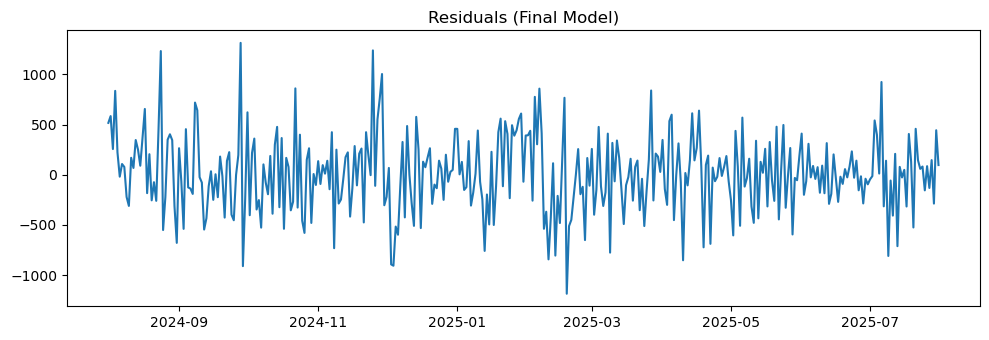


Candidate comparison (sorted by MAE):
                       name     order seasonal_order        MAE       RMSE        R2
grid_(2, 0, 2)_(1, 1, 0, 7) (2, 0, 2)   (1, 1, 0, 7) 287.112080 383.605692 -0.384983
grid_(1, 1, 2)_(1, 1, 1, 7) (1, 1, 2)   (1, 1, 1, 7) 294.922400 405.326059 -0.546263
grid_(1, 1, 1)_(1, 1, 1, 7) (1, 1, 1)   (1, 1, 1, 7) 297.106913 407.717996 -0.564567
grid_(0, 1, 1)_(0, 1, 1, 7) (0, 1, 1)   (0, 1, 1, 7) 308.575231 417.649503 -0.641717
grid_(2, 1, 1)_(1, 1, 1, 7) (2, 1, 1)   (1, 1, 1, 7) 313.324767 421.717589 -0.673854
                 auto_arima (3, 0, 0)   (2, 0, 0, 7) 406.147017 501.574160 -1.367798
grid_(3, 0, 0)_(2, 0, 0, 7) (3, 0, 0)   (2, 0, 0, 7) 406.147017 501.574160 -1.367798


In [34]:
# ================================
# DAILY SALES FORECAST — SARIMA
# ================================
# Requirements (install in a cell if needed):
# pip install statsmodels pmdarima scikit-learn matplotlib pandas numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Try to import auto_arima; it's optional
try:
    from pmdarima import auto_arima
    HAS_AUTO = True
except Exception:
    HAS_AUTO = False

# ---------- Helper utils ----------
def make_daily_series(df, date_col="order_day", value_col="total_sales"):
    s = (df.groupby(date_col)[value_col]
           .sum()
           .sort_index())
    # Reindex to a full daily range and fill missing with 0
    idx = pd.date_range(s.index.min(), s.index.max(), freq="D")
    s = s.reindex(idx).fillna(0.0)
    s.index.name = date_col
    return s.to_frame(name=value_col)

def metrics(y_true, y_pred, prefix=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{prefix}MAE: {mae:.2f}  RMSE: {rmse:.2f}  R²: {r2:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def plot_test_fit(train_df, test_df, y_pred, title):
    plt.figure(figsize=(9,5))
    plt.plot(train_df.index, train_df.values, label="Train", alpha=0.6)
    plt.plot(test_df.index,  test_df.values,  label="Actual (Test)", linewidth=2)
    plt.plot(test_df.index,  y_pred,          label="Predicted (Test)", linewidth=2)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def fit_sarima(y, order, seasonal_order):
    model = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    return model.fit(disp=False)

# ---------- 1) Load & prep ----------
df = pd.read_csv("cleaned_data.csv")
df["order_day"] = pd.to_datetime(df["order_day"])

daily = make_daily_series(df, "order_day", "total_sales")
y = daily["total_sales"]

# ---------- 2) Train/test split ----------
TEST_DAYS = 30
train = y.iloc[:-TEST_DAYS]
test  = y.iloc[-TEST_DAYS:]

# ---------- 3) Baseline (Naïve: yesterday = today) ----------
naive_pred = test.shift(1).fillna(train.iloc[-1])
print("Baseline (Naïve) on test:")
base_scores = metrics(test, naive_pred, prefix="  ")

# ---------- 4) Candidate models ----------
candidates = []

# 4a) auto_arima suggestion (weekly seasonality m=7), if available
if HAS_AUTO:
    auto = auto_arima(
        train,
        seasonal=True, m=7,
        start_p=0, start_q=0, max_p=3, max_q=3,
        start_P=0, start_Q=0, max_P=2, max_Q=2,
        d=None, D=None, stepwise=True, trace=False,
        error_action="ignore", suppress_warnings=True,
        information_criterion="aic"
    )
    order_auto, seasonal_order_auto = auto.order, auto.seasonal_order
    candidates.append(("auto_arima", order_auto, seasonal_order_auto))

# 4b) small manual grid (robust starters)
manual_grid = [
    ((1,1,1), (1,1,1,7)),
    ((2,1,1), (1,1,1,7)),
    ((1,1,2), (1,1,1,7)),
    ((3,0,0), (2,0,0,7)),
    ((0,1,1), (0,1,1,7)),
    ((2,0,2), (1,1,0,7)),
]
for o, so in manual_grid:
    candidates.append((f"grid_{o}_{so}", o, so))

# ---------- 5) Evaluate candidates on the test window ----------
results_table = []
best = None
for name, o, so in candidates:
    try:
        m = fit_sarima(train, order=o, seasonal_order=so)
        pred = m.get_forecast(steps=len(test)).predicted_mean
        scores = metrics(test, pred, prefix=f"[{name}] ")
        results_table.append((name, o, so, scores["MAE"], scores["RMSE"], scores["R2"]))
        if best is None or scores["MAE"] < best["MAE"]:
            best = {"name": name, "order": o, "so": so, **scores}
    except Exception as e:
        print(f"[{name}] failed: {e}")

print("\nBest by MAE:", best)

# ---------- 6) Plot best test fit ----------
best_model = fit_sarima(train, order=best["order"], seasonal_order=best["so"])
best_pred  = best_model.get_forecast(steps=len(test)).predicted_mean
plot_test_fit(train, test, best_pred, 
              title=f"SARIMA Daily — Predicted vs Actual (Best={best['name']}, order={best['order']}, so={best['so']})")

# ---------- 7) Refit best on ALL data & forecast to 2025-12-31 ----------
final_model = fit_sarima(y, order=best["order"], seasonal_order=best["so"])

# steps to end of 2025
horizon_days = (pd.to_datetime("2025-12-31") - y.index.max()).days
horizon_days = max(horizon_days, 1)
fc = final_model.get_forecast(steps=horizon_days)
fc_mean = fc.predicted_mean
fc_ci   = fc.conf_int()

# Optional: clip negatives if you know sales can't go below 0
fc_mean_clipped = np.clip(fc_mean, 0, None)
fc_ci_clipped = fc_ci.copy()
fc_ci_clipped.iloc[:, 0] = np.clip(fc_ci_clipped.iloc[:, 0], 0, None)

# ---------- 8) Plot historical + forecast ----------
plt.figure(figsize=(12,6))
plt.plot(y.index, y.values, label="Observed", alpha=0.75)
plt.plot(fc_mean.index, fc_mean_clipped.values, label="Forecast", linewidth=2)
plt.fill_between(fc_ci_clipped.index,
                 fc_ci_clipped.iloc[:,0].values,
                 fc_ci_clipped.iloc[:,1].values,
                 color="gray", alpha=0.25, label="95% CI")
plt.title(f"SARIMA — Daily Sales Forecast through 2025-12-31\nBest={best['name']}  order={best['order']}  so={best['so']}")
plt.xlabel("Date"); plt.ylabel("Total Sales")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 9) Residual diagnostics ----------
resid = final_model.resid
print("Residual mean:", round(float(resid.mean()), 2), "  Std:", round(float(resid.std()), 2))

plt.figure(figsize=(10,3.5))
plt.plot(resid)
plt.title("Residuals (Final Model)")
plt.tight_layout()
plt.show()

# ---------- 10) (Optional) Compare table ----------
if results_table:
    res_df = pd.DataFrame(results_table, columns=["name","order","seasonal_order","MAE","RMSE","R2"]).sort_values("MAE")
    print("\nCandidate comparison (sorted by MAE):")
    print(res_df.to_string(index=False))

#### save to csv

In [35]:
fc = final_model.get_forecast(steps=horizon_days)
fc_mean = fc.predicted_mean
fc_ci   = fc.conf_int()

In [36]:
# --- Build forecast dataframe ---
forecast_df = pd.DataFrame({
    "date": fc_mean.index,
    "forecast": np.clip(fc_mean.values, 0, None),  # clip negatives to 0
    "lower": np.clip(fc_ci.iloc[:,0].values, 0, None),
    "upper": np.clip(fc_ci.iloc[:,1].values, 0, None)
})

# Save to CSV
forecast_df.to_csv("daily_sales_forecast_2025.csv", index=False)

print("✅ Forecast saved to daily_sales_forecast_2025.csv")
print(forecast_df.head())  # preview first few rows

✅ Forecast saved to daily_sales_forecast_2025.csv
        date     forecast       lower        upper
0 2025-08-01   993.108881  245.146417  1741.071346
1 2025-08-02   944.823792  110.950562  1778.697021
2 2025-08-03   872.352755    0.000000  1747.289096
3 2025-08-04  1082.710586  168.577160  1996.844012
4 2025-08-05   992.281200   55.845654  1928.716746
